## Importing basic libraries

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

## Collecting data

In [13]:
raw_data = pd.read_csv('MSFT_2006-01-01_to_2018-01-01.csv')
data = raw_data.copy()

In [14]:
data.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,26.25,27.00,26.10,26.84,79974418,MSFT
1,2006-01-04,26.77,27.08,26.77,26.97,57975661,MSFT
2,2006-01-05,26.96,27.13,26.91,26.99,48247610,MSFT
3,2006-01-06,26.89,27.00,26.49,26.91,100969092,MSFT
4,2006-01-09,26.93,27.07,26.76,26.86,55627836,MSFT


To predict one year of stock price , we don't actually need 12 years of data. Hence, it will be better if we gather the last 6 years of data.

In [15]:
data['Date'] = pd.to_datetime(data.Date,format='%Y-%m-%d')
data.index = data['Date']

#sorting
data = data.sort_index(ascending=True, axis=0)

data = data['2012-01-01' :]
data.head()

,Date,Open,High,Low,Close,Volume,Name
Date,,,,,,,
2012-01-03,2012-01-03,26.55,26.96,26.39,26.76,64735391,MSFT
2012-01-04,2012-01-04,26.82,27.47,26.78,27.40,80519402,MSFT
2012-01-05,2012-01-05,27.38,27.73,27.29,27.68,56082205,MSFT
2012-01-06,2012-01-06,27.53,28.19,27.52,28.10,99459469,MSFT
2012-01-09,2012-01-09,28.05,28.10,27.72,27.74,59708266,MSFT


### The profit or loss calculation is usually determined by the closing price of a stock for the day, hence we will consider the closing price as the target variable. Let’s plot the target variable to understand its pattern.

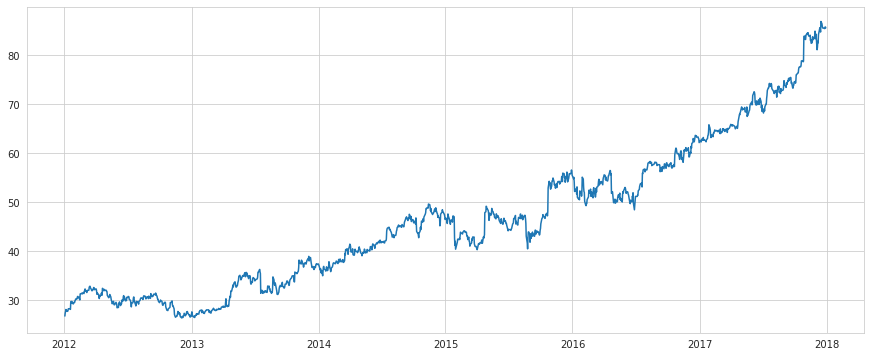

In [16]:
plt.figure(figsize = (15,6))
plt.plot(data.Close)
plt.show()

For our problem statement, we do not have a set of independent variables. We have only the dates instead. Let's use the date column to extract features like – day, month, year,  day of the week etc.

We will create a seperate dataset with only the Date and closing price columns. The date column will be the index as usual.

In [17]:
new_data = pd.DataFrame(data = data , columns=['Date','Close'])

new_data.head()

,Date,Close
Date,,
2012-01-03,2012-01-03,26.76
2012-01-04,2012-01-04,27.40
2012-01-05,2012-01-05,27.68
2012-01-06,2012-01-06,28.10
2012-01-09,2012-01-09,27.74


#### **1. Fearure Creation based on dates**

Next, we will create different features based on the date like day of week, day of year , etc. 

We will use add_datepart module from tabular package in fastai framework.

In [18]:
import fastai
from fastai.tabular import  add_datepart

add_datepart(new_data, 'Date')
new_data.drop('Elapsed', axis=1, inplace=True)  #elapsed will be the time stamp

new_data.head()

,Close,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
Date,,,,,,,,,,,,,
2012-01-03,26.76,2012,1,1,3,1,3,False,False,False,False,False,False
2012-01-04,27.40,2012,1,1,4,2,4,False,False,False,False,False,False
2012-01-05,27.68,2012,1,1,5,3,5,False,False,False,False,False,False
2012-01-06,28.10,2012,1,1,6,4,6,False,False,False,False,False,False
2012-01-09,27.74,2012,1,2,9,0,9,False,False,False,False,False,False


This creates features such as:

‘Year’, ‘Month’, ‘Week’, ‘Day’, ‘Dayofweek’, ‘Dayofyear’, ‘Is_month_end’, ‘Is_month_start’, ‘Is_quarter_end’, ‘Is_quarter_start’,  ‘Is_year_end’, and  ‘Is_year_start’.

To learn about fastai framework, visit [here](https://docs.fast.ai/)

#### **2. Handling the categorical variables.**

Here, the main categorical variables are : ‘Is_month_end’, ‘Is_month_start’, ‘Is_quarter_end’, ‘Is_quarter_start’, ‘Is_year_end’, and ‘Is_year_start’

Since these are all binary, LabelEncoder from sklearn package will do just fine.

In [19]:
from sklearn.preprocessing import LabelEncoder

cols = ['Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']

encoder = LabelEncoder()

for x in cols:
  new_data[x] = encoder.fit_transform(new_data[x].values)

new_data.head()


,Close,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
Date,,,,,,,,,,,,,
2012-01-03,26.76,2012,1,1,3,1,3,0,0,0,0,0,0
2012-01-04,27.40,2012,1,1,4,2,4,0,0,0,0,0,0
2012-01-05,27.68,2012,1,1,5,3,5,0,0,0,0,0,0
2012-01-06,28.10,2012,1,1,6,4,6,0,0,0,0,0,0
2012-01-09,27.74,2012,1,2,9,0,9,0,0,0,0,0,0


#### **3. Moving Average**

Another important feature in time series analysis is the moving average feature.

Calculating some statistical values based on past values is called the rolling window method because the window would be different for every data point.

We will start off with monthly moving averages.

In [20]:
new_data['Monthly_moving_average'] = new_data['Close'].rolling(window=30).mean()# window = 30  means monthly average
new_data.head()

,Close,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Monthly_moving_average
Date,,,,,,,,,,,,,,
2012-01-03,26.76,2012,1,1,3,1,3,0,0,0,0,0,0,NaN
2012-01-04,27.40,2012,1,1,4,2,4,0,0,0,0,0,0,NaN
2012-01-05,27.68,2012,1,1,5,3,5,0,0,0,0,0,0,NaN
2012-01-06,28.10,2012,1,1,6,4,6,0,0,0,0,0,0,NaN
2012-01-09,27.74,2012,1,2,9,0,9,0,0,0,0,0,0,NaN


In [21]:
# Replacing the NaN values with 0

new_data['Monthly_moving_average'] = new_data['Monthly_moving_average'].fillna(0)

#### **4. Expanding moving average/ Expanding moving window**

This is simply an advanced version of the rolling window technique. In the case of a rolling window, the size of the window is constant while the window slides as we move forward in time. Hence, we consider only the most recent values and ignore the past values.

The idea behind the expanding window feature is that it takes all the past values into account.

In [22]:
new_data['Expanding_mean'] = new_data['Close'].expanding(2).mean()

#Filling NaN value
new_data['Expanding_mean'] = new_data['Expanding_mean'].fillna(0)
new_data.head()

,Close,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Monthly_moving_average,Expanding_mean
Date,,,,,,,,,,,,,,,
2012-01-03,26.76,2012,1,1,3,1,3,0,0,0,0,0,0,0.0,0.000
2012-01-04,27.40,2012,1,1,4,2,4,0,0,0,0,0,0,0.0,27.080
2012-01-05,27.68,2012,1,1,5,3,5,0,0,0,0,0,0,0.0,27.280
2012-01-06,28.10,2012,1,1,6,4,6,0,0,0,0,0,0,0.0,27.485
2012-01-09,27.74,2012,1,2,9,0,9,0,0,0,0,0,0,0.0,27.536


Finally let's save this in a csv file for final use in Model.

In [23]:
new_data.to_csv('MSFT Stock_Market_final_data.csv')